In [242]:
# ================== Global parameters for fonts & sizes =================
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'legend.fontsize': font_size, 
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': font_size, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

In [571]:
file_path = r"C:\Users\samha\Documents\CANVAS\data"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from scipy.optimize import fmin
%matplotlib qt
%matplotlib inline

data = pd.read_csv(file_path + r'/data_sample_4.csv', index_col = 0)
data.sort_index(inplace=True)
data.index = pd.to_datetime(data.index)

data['unix_ts'] = data.index.astype(int) / 10**9
data['x_fit'] = (data['unix_ts'] - data['unix_ts'][0])/60 #this is necessary for the fitting purpose since the precision is broken if we use alarge number.

In [572]:
def filter_sunrise_sunset(df):
    """Filter a D-PV Time series data based on its estimated sunrise and sunset time.

    Args:
    df (df): D-PV Time series data

    Returns:
    sunrise (timestamp): estimated sunrise time (when power is >10 W for the first time in a day)
    sunset (timestamp): the opened ghi data (when power is >10 W for the last time in a day)
    df (df): filtered D-PV Time series data
    """
    if df is None or len(df.index) == 0:
        return None

    tmpDF = df.loc[df['power'] > 10]
    if len(tmpDF.index) == 0:
        return None

    sunrise = tmpDF.index[0]
    sunset = tmpDF.index[-1]

    df = df.loc[df.index > sunrise]
    df = df.loc[df.index < sunset]

    return sunrise, sunset, df

def filter_curtailment(df):
    """Take the power data and row number from D-PV time-series data & filter out curtailment. Will be used for polyfit regression.

    Args:
    df (df): Time-series D-PV data with power column and timestamp as an index

    Returns:
    powerArray (pd series): filtered power data
    timeArray (pd datetime): filtered row number data
    """
    
    maxDailyPower = max(df.power)
    if len(df.loc[df['power'] == maxDailyPower].index) > 1:
        return None, None
    
    filter_first_half = []
    filter_second_half = []
    powerArray = df.power
    xArray = df['x_fit']
    
    halfFlag = True  # True is first half, False is second half
    last_highest_power = 0
    
    for power in powerArray:

        # IF power IS GREATER THAN last_highest_power THEN INCLUDE power AND INCREASE last_highest_power
        if power > last_highest_power:
            last_highest_power = power
            filter_first_half.append(True)
        else:
            filter_first_half.append(False)

        if power == maxDailyPower:
            break
            
    last_highest_power = 0
    
    # PERFORM SAME FILTER ON SECOND SIDE OF POWER ARRAY
    for power in powerArray.iloc[::-1]:

        if power == maxDailyPower:
            break

        if power > last_highest_power:
            last_highest_power = power
            filter_second_half.append(True)
        else:
            filter_second_half.append(False)
            
    # COMBINE TO FILTERED SIDES
    filter_second_half.reverse()
    filterArray = filter_first_half + filter_second_half
    return xArray[filterArray], powerArray[filterArray]

In [573]:
sunrise, sunset, data = filter_sunrise_sunset(data)

In [574]:
data

,c_id,energy,power,reactive_power,voltage,duration,unix_ts,x_fit
Timestamp,,,,,,,,
2020-04-13 06:45:55+09:30,1165442853,738,12.300000,940,246.6,60,1.586726e+09,405.0
2020-04-13 06:46:55+09:30,1165442853,846,14.100000,665,246.5,60,1.586726e+09,406.0
2020-04-13 06:47:55+09:30,1165442853,941,15.683333,511,246.7,60,1.586726e+09,407.0
2020-04-13 06:48:55+09:30,1165442853,1045,17.416667,423,247.1,60,1.586726e+09,408.0
2020-04-13 06:49:55+09:30,1165442853,1147,19.116667,321,247.0,60,1.586726e+09,409.0
...,...,...,...,...,...,...,...,...
2020-04-13 17:33:55+09:30,1165442853,1686,28.100000,-420,244.3,60,1.586765e+09,1053.0
2020-04-13 17:34:55+09:30,1165442853,1536,25.600000,-434,244.1,60,1.586765e+09,1054.0
2020-04-13 17:36:55+09:30,1165442853,1225,20.416667,-400,244.0,60,1.586765e+09,1056.0


In [575]:
x, y = filter_curtailment(data)

In [576]:
x_for_fitting = np.array(x)
y_for_fitting = np.array(y)

In [577]:
#x = np.array(data_filtered['unix_ts'])  - 1586760294
#y = np.array(data_filtered['power'])

#x = np.array([-3, -2, -1, 0, 1, 2, 3])
#y = np.array([9, 4, 1, 2, 1, 4, 9])

def func(a,x):
    y = a[0] * x**2 + a[1] * x + a[2]
    return y

def sum_squared_error(a):
    y_fit = func(a,x_for_fitting)
    sum_squared_error = sum((y_fit - y)**2)
    return sum_squared_error

In [578]:
con_func_1 = lambda x: func(a = x, x = x_for_fitting) - y_for_fitting
must_higher = NonlinearConstraint(con_func_1, 0, np.inf)

In [579]:
res = minimize(sum_squared_error, x0 = [0, 0, 0], method = 'trust-constr', constraints = must_higher)
#trust-constr is used bcs we have constrain to add

C:\Users\samha\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [580]:
res

 barrier_parameter: 0.020000000000000004
 barrier_tolerance: 0.020000000000000004
          cg_niter: 87
      cg_stop_cond: 4
            constr: [array([2.57315358e+02, 2.85087433e+02, 3.12984952e+02, 3.40641248e+02,
       3.68239655e+02, 3.95630173e+02, 4.21796135e+02, 4.28787541e+02,
       4.09604392e+02, 4.06030019e+02, 4.20681091e+02, 4.37690941e+02,
       4.54392901e+02, 4.70786972e+02, 4.86239821e+02, 4.97801447e+02,
       4.95238518e+02, 4.26801032e+02, 4.26372324e+02, 4.32352394e+02,
       4.38841240e+02, 4.43922198e+02, 4.49495267e+02, 4.54360446e+02,
       4.60467737e+02, 4.63667138e+02, 4.66908650e+02, 4.70275606e+02,
       4.73084673e+02, 4.73669184e+02, 4.75712472e+02, 4.78064538e+02,
       4.78892049e+02, 4.80628336e+02, 4.80840068e+02, 4.80860578e+02,
       4.81239865e+02, 4.82377929e+02, 4.82691438e+02, 4.82580390e+02,
       4.80394787e+02, 4.79767961e+02, 4.78366580e+02, 4.76457309e+02,
       4.75173483e+02, 4.72015101e+02, 4.70148829e+02, 4.67624668e+02,


In [581]:
a = res.x

In [582]:
data['power_expected'] = func(a, np.array(data['x_fit']))

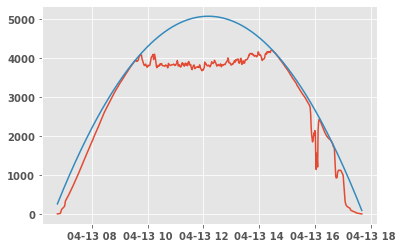

In [583]:
plt.plot(data.index, data['power'])
plt.plot(data.index, data['power_expected'])

plt.show()